<a href="https://colab.research.google.com/github/wilsdefots/keyboard-writing-speed/blob/main/tp3_Apprentissage_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### importation des librairies utiles et des données

In [11]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, learning_curve
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
import sys
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

In [5]:
#from google.colab import drive
drive.mount('/content/drive')
customer = pd.read_csv("/content/drive/My Drive/Customer.csv", na_values=['?', 'unknown'])
population = pd.read_csv("/content/drive/My Drive/CountryPopulation.csv")
gdp = pd.read_csv("/content/drive/My Drive/CountryGDP.csv")

#Lorsque necessare, on fera la jointure des 3 bases de données
def joindre_database(db1, db2, cle_jointure):
    db1.columns = [col.lower() for col in db1.columns]
    db2.columns = [col.lower() for col in db2.columns]
    db = pd.merge(db1, db2, on=cle_jointure.lower(), how='inner')
    return db

#db = joindre_database(customer, population, 'Country')
#df = joindre_database(db, gdp, 'Country')
df = customer
df.head()

Mounted at /content/drive


,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue
0,41.0,6.0,28.0,Fem,False,4.0,China,113.0
1,34.0,4.0,15.5,Fem,True,2.0,China,36.0
2,38.0,5.0,NaN,Fem,False,7.0,China,111.0
3,20.0,1.0,44.0,Fem,False,2.0,China,71.0
4,39.0,10.0,10.0,Fem,True,4.0,China,80.0


### Préparation du pipeline pour traiter les données

In [6]:
def convertir_binaire(data ,  colonne):
  data = data.copy()
  data['revenue_bin'] = np.where(data[colonne] > np.mean(data[colonne]), 1, 0)
  return data
df_bin  = convertir_binaire(df, 'revenue')
df_bin.head()


,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue,revenue_bin
0,41.0,6.0,28.0,Fem,False,4.0,China,113.0,0
1,34.0,4.0,15.5,Fem,True,2.0,China,36.0,0
2,38.0,5.0,NaN,Fem,False,7.0,China,111.0,0
3,20.0,1.0,44.0,Fem,False,2.0,China,71.0,0
4,39.0,10.0,10.0,Fem,True,4.0,China,80.0,0


In [7]:
seed = 2025
train_set_bin, test_set_bin = train_test_split(df_bin, test_size=0.2,  random_state=seed)
X_train_bin = train_set_bin.drop(columns = ["revenue_bin","revenue"], axis=1)
Y_train_bin = train_set_bin["revenue_bin"]
X_test_bin = test_set_bin.drop(columns=["revenue_bin","revenue"], axis = 1)
Y_test_bin = test_set_bin["revenue_bin"]

In [8]:
def nettoyageOutliers(df: pd.DataFrame) -> pd.DataFrame:
    Q25 = df.quantile(0.25)
    Q75 = df.quantile(0.75)
    IQR = Q75 - Q25
    SeuilMin = Q25 - 1.5 * IQR
    SeuilMax = Q75 + 1.5 * IQR
    return df.clip(SeuilMin, SeuilMax, axis=1)

def bornage(data):
    return nettoyageOutliers(pd.DataFrame(data))

#### Fonction de conversion en numérique
def toNum(data: pd.DataFrame):
    if 'first_item_prize' in data.columns:
        data['first_item_prize'] = pd.to_numeric(data['first_item_prize'], errors='coerce')
    return data

### Pipeline numérique
num_transformer = Pipeline([
    ('toNum', FunctionTransformer(toNum, feature_names_out='one-to-one')),  # Correction ici
    ('imputer', SimpleImputer(strategy="median")),
    ('clamp', FunctionTransformer(bornage, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

### Pipeline catégoriel
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Correction ici
])

### Pipeline complet
full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

# Transformation des données
X_train_pret = pd.DataFrame(full_pipeline.fit_transform(X_train_bin))
X_test_pret = pd.DataFrame(full_pipeline.transform(X_test_bin))

### Question 2.1.1 : Entrainment du PMC pour le classeur binaire

In [32]:
param_grid = {
    'hidden_layer_sizes':
    [(n,) for n in range(10, 101, 10)] +
    [(n, n) for n in range(10, 101, 10)] +
    [(n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n, n) for n in range(10, 101, 10)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'max_iter': [100, 200, 300, 400, 500]
}
gpus = tf.config.experimental.list_physical_devices('GPU')
mlp = MLPClassifier(random_state = seed)

random_search = RandomizedSearchCV(
    mlp, param_distributions=param_grid,
    cv=3, scoring='accuracy',
    n_jobs=-1, return_train_score=True
)

random_search.fit(X_train_pret, Y_train_bin)

best_params = random_search.best_params_
print(f"Meilleure architecture trouvée : {best_params['hidden_layer_sizes']}")
print(f"Couches cachées, activation={best_params['activation']}, max_iter={best_params['max_iter']}")
print(f"Meilleur score sur validation croisée : {random_search.best_score_:.4f}")

Y_pred = random_search.best_estimator_.predict(X_test_pret)
print("Accuracy sur le test set :", accuracy_score(Y_test_bin, Y_pred))


Meilleure architecture trouvée : (10, 10, 10)
Couches cachées, activation=logistic, max_iter=300
Meilleur score sur validation croisée : 0.8522
Accuracy sur le test set : 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


La meilleure architechture trouvée est celle avec 3 couches de 10 neurones chacune. Le Pronlème qui se pose est que l'algorithme ne converge pas à cause du fait qu'on n a pas fait suffisament d'itérations. Pour résoudre cela. nous allons augmenter le nombre d'itérations

In [36]:
#le meilleur modele est le suivant :
meilleur_modele_mpc = MLPClassifier(hidden_layer_sizes = (10,10,10),
                      activation='logistic',max_iter=500)
meilleur_modele_mpc.fit(X_train_pret,Y_train_bin)
print(f'accuracy = {round(meilleur_modele_mpc.score(X_test_pret, Y_test_bin),2)}')

accuracy = 0.87


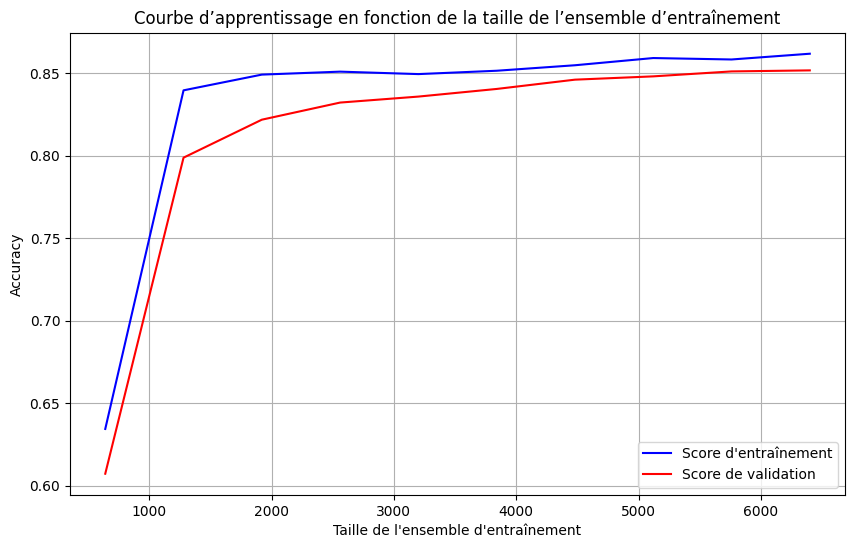

In [37]:
#On trace la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(
    random_search.best_estimator_,
    X_train_pret, Y_train_bin,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color="blue", label="Score d'entraînement")
plt.plot(train_sizes, val_mean, color="red", label="Score de validation")

plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Accuracy")
plt.title("Courbe d’apprentissage en fonction de la taille de l’ensemble d’entraînement")
plt.legend()
plt.grid(True)
plt.show()

### Question 2.1.2 : Entrainement du PMC pour un classeur trois classes

In [56]:
def classer3_classes(data, colonne):
    data = data.copy()
    q1 = data[colonne].quantile(0.25)
    q3 = data[colonne].quantile(0.75)

    data['revenue3'] = np.where(
        data[colonne] <= q1, 'bas',
        np.where(data[colonne] <= q3, 'moyen', 'eleve')
    )

    return data
df3 = classer3_classes(df, 'revenue')
df3.head()


,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue,revenue3
0,41.0,6.0,28.0,Fem,False,4.0,China,113.0,moyen
1,34.0,4.0,15.5,Fem,True,2.0,China,36.0,bas
2,38.0,5.0,NaN,Fem,False,7.0,China,111.0,moyen
3,20.0,1.0,44.0,Fem,False,2.0,China,71.0,moyen
4,39.0,10.0,10.0,Fem,True,4.0,China,80.0,moyen


In [24]:
train_set3, test_set3 = train_test_split(df3, test_size=0.2, random_state=seed)
X_train3 = train_set3.drop(columns=["revenue", "revenue3"], axis=1)
Y_train3 = train_set3["revenue3"]
X_test3 = test_set3.drop(columns=["revenue", "revenue3"], axis=1)
Y_test3 = test_set3["revenue3"]

full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

X_train_pret = pd.DataFrame(full_pipeline.fit_transform(X_train3))
X_test_pret = pd.DataFrame(full_pipeline.transform(X_test3))


gpus = tf.config.experimental.list_physical_devices('GPU')

#On entraine le perceptron
param_grid = {
    'hidden_layer_sizes':
    [(n,) for n in range(10, 101, 10)] +
    [(n, n) for n in range(10, 101, 10)] +
    [(n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n) for n in range(10, 101, 10)] +
    [(n, n, n, n, n) for n in range(10, 101, 10)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'max_iter': [10, 50, 100, 200, 300, 400, 500]
}

mlp = MLPClassifier(random_state = seed)

random_search = RandomizedSearchCV(
    mlp, param_distributions=param_grid,
    cv=3, scoring='accuracy',
    n_jobs=-1, return_train_score=True
)

random_search.fit(X_train_pret, Y_train3)

best_params = random_search.best_params_
print(f"Meilleure architecture trouvée : {best_params['hidden_layer_sizes']}")
print(f"Couches cachées, activation={best_params['activation']}, max_iter={best_params['max_iter']}")
print(f"Meilleur score sur validation croisée : {random_search.best_score_:.4f}")

Y_pred = random_search.best_estimator_.predict(X_test_pret)
print("Accuracy sur le test set :", accuracy_score(Y_test3, Y_pred))

Meilleure architecture trouvée : (40, 40, 40, 40)
Couches cachées, activation=logistic, max_iter=400
Meilleur score sur validation croisée : 0.7585
Accuracy sur le test set : 0.78


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


On constate que la meilleure architechture trouvée est celle avec 5 couches, comportant chacune 50 neurones. on a  un avertissement concernant la non convergeance de l'optimiseur choisit pour ce modèle, avec seulement 50 itérations. On va donc reprendre la même architechture, mais en augmentant le nombre d'itérations

In [26]:
#le meilleur modele est le suivant :
meilleur_modele_mpc = MLPClassifier(hidden_layer_sizes = (40,40,40,40),
                      activation='logistic',max_iter=500)
meilleur_modele_mpc.fit(X_train_pret,Y_train3)
print(f'accuracy = {round(meilleur_modele_mpc.score(X_test_pret, Y_test3),2)}')

accuracy = 0.79


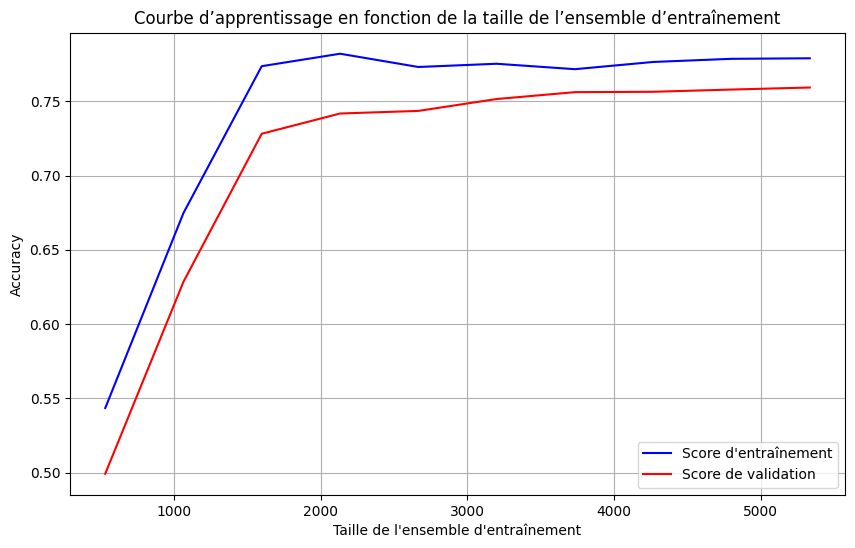

In [27]:
train_sizes, train_scores, val_scores = learning_curve(
    random_search.best_estimator_,
    X_train_pret, Y_train3,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean,  color="blue", label="Score d'entraînement")
plt.plot(train_sizes, val_mean,  color="red", label="Score de validation")

plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Accuracy")
plt.title("Courbe d’apprentissage en fonction de la taille de l’ensemble d’entraînement")
plt.legend()
plt.grid(True)
plt.show()

Les performences sont moins bonne que pour un classeur binaire. De plus  le modèle sur-ajuste aussi, surtout avec les dennées de petite taille. Lorsqu'on augmente la taille, le modèle s'améliore mais pas assez pour conclure.

Une solution peut être d'ajouter des observation ou  **d'enrichir les données**

### Question2.2.1 :
Cette section est simplement le copier-collé de ce qui a été fait en classe, je n'ai rien rajouté, sinon les commentaires. Les codes ne m'appartiennent pas

In [38]:
assert sys.version_info >= (3, 5)
assert tf.__version__ >= "2.0"
np.random.seed(2025)
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [45]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
x_train_full.shape
#x_train_full.dtype

(60000, 28, 28)

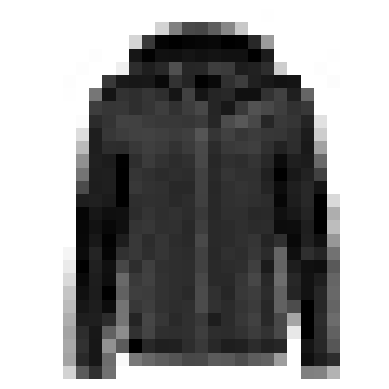

In [46]:
x_valid, x_train = x_train_full[:5000] / 255., x_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255.

plt.imshow(x_train[0], cmap="binary")
plt.axis('off')
plt.show()

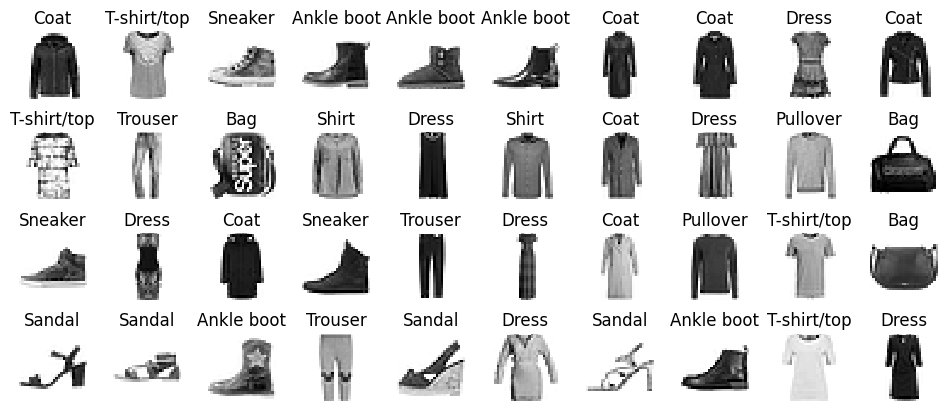

In [61]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Créons un modele PMC avec l'API Sequential.
1. La premiere ligne du code crée un modèle Sequential. C'est la maniere la plus simple de créer un RNA avec keras. Il est constitué d'une seule pile de couches connectées sous forme séquentielle.
2. Ensuite, nous ajoutons la couche Flatten-aplatissement- dans le but de convertir chaque image d'entrée en un tableau monodimensionnel
3. Ensuite nous ajoutons une couche cachée de 300 neurones. Elle utilise la fonction d'activation ReLU.
4. on ajoute une cachée Dense de 100 neurones, avec une fonction d'activation ReLU.
5. Enfin une couche de sortie Dense avec 10 neurones (un par classe) en utilisant la fonction d'activation softmax.

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
keras.backend.clear_session() # re-initialiser les états internes de tensorflow
np.random.seed(2025)
tf.random.set_seed(2025)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=30,
                    validation_data=(x_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6845 - loss: 1.0027 - val_accuracy: 0.8232 - val_loss: 0.5214
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8240 - loss: 0.5055 - val_accuracy: 0.8448 - val_loss: 0.4617
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8411 - loss: 0.4523 - val_accuracy: 0.8554 - val_loss: 0.4286
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8514 - loss: 0.4225 - val_accuracy: 0.8630 - val_loss: 0.4056
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8593 - loss: 0.4010 - val_accuracy: 0.8684 - val_loss: 0.3888
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8654 - loss: 0.3841 - val_accuracy: 0.8720 - val_loss: 0.3762
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8712 - loss: 0.3702 - val_accuracy: 0.8742 - val_loss: 0.3663
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8748 - loss: 0.3580 - 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


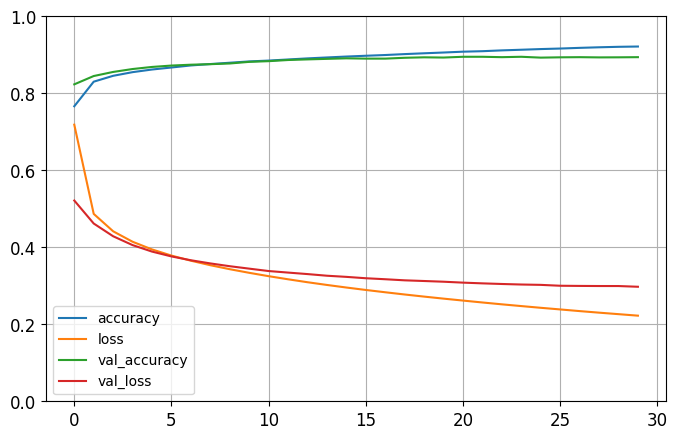

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8806 - loss: 0.3392
score sur l ensemble test  = 0.8791000247001648


In [35]:
print(history.epoch)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
print(f'score sur l ensemble test  = {model.evaluate(x_test, y_test)[1]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


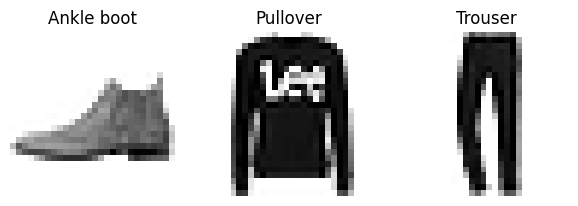

In [36]:
x_new = x_test[:3]
y_proba = model.predict(x_new)
y_proba.round(2)
y_pred = np.argmax(model.predict(x_new), axis=-1)
y_pred

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(x_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


### Question 2.2.2

Implantons un CNN dont on déterminera l'architechture qui doit améliorer la performance du modèle obtenu précédament

In [62]:
data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
start = time.time()
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))
end = time.time()
print(f"Temps d'entraînement : {(end - start):.2f} secondes")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6750 - loss: 0.8903 - val_accuracy: 0.8329 - val_loss: 0.4436
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8404 - loss: 0.4408 - val_accuracy: 0.8647 - val_loss: 0.3752
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8681 - loss: 0.3689 - val_accuracy: 0.8723 - val_loss: 0.3506
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8816 - loss: 0.3272 - val_accuracy: 0.8792 - val_loss: 0.3359
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8933 - loss: 0.2965 - val_accuracy: 0.8802 - val_loss: 0.3273
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9004 - loss: 0.2748 - val_accuracy: 0.8884 - val_loss: 0.3132
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9068 - loss: 0.2528 - val_accuracy: 0.8877 - val_loss: 0.3167
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9130 - loss: 0.2388

### Question 2.2.3
Courbe d'apprentissage du CNN obtenu en 2.2.2

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


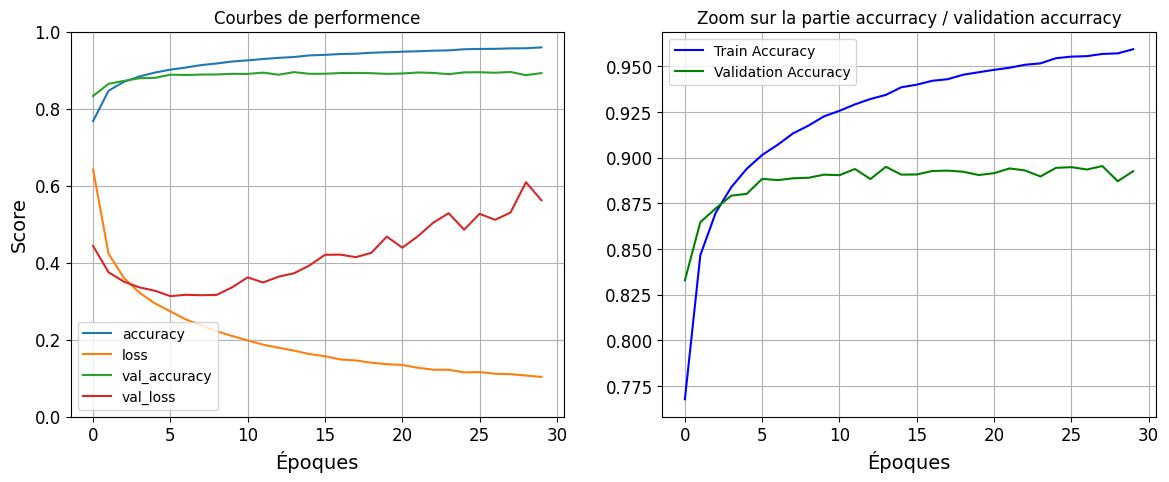

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8941 - loss: 0.5794
score sur l ensemble test  = 0.8925999999046326


In [63]:
print(history.epoch)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pd.DataFrame(history.history).plot(ax=axes[0])
axes[0].set_title("Courbes de performence")
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Score')
axes[0].grid(True)
axes[0].set_ylim(0, 1)


axes[1].plot(history.history['accuracy'], label='Train Accuracy', color = 'blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy',color = 'green')
axes[1].set_xlabel('Époques')
axes[1].set_title("Zoom sur la partie accurracy / validation accurracy")
axes[1].legend()
axes[1].grid(True)


plt.show()

# Évaluation du modèle
print(f'score sur l ensemble test  = {model.evaluate(x_test, y_test)[1]}')


À partir de la courbe, On constate que le modèle CNN a un meilleur score que le reseau de neurones profond. Bien qu'il est tout de même important de mentionner  qu'à cause de sa multitude de paramètres, il sur ajuste les données.
On devra donc penser à un enrichissement des données pour tenter de résoudre le problème de sur ajustement.

### Question 2.2.4 :
Entrainement du CNN obtenu en 2.2.2 en utilisant la technique d’augmentation des données à l’aide de l’outil « ImageDataGenerator » de Keras  (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/Image DataGenerator).  

In [68]:
image_aug = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.1,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
#On prend la meme architechture que précédament
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


#print("GPU disponible :", tf.config.list_physical_devices('GPU'))

with tf.device('/GPU:0'):
  start = time.time()
  history = model.fit(image_aug.flow(x_train, y_train, batch_size=32),
                        epochs=15, validation_data=(x_test, y_test))
  end = time.time()
print(f"Temps d'entraînement : {(end - start):.2f} secondes")
model.evaluate(x_test, y_test)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.5899 - loss: 1.1163 - val_accuracy: 0.7897 - val_loss: 0.5692
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.7595 - loss: 0.6542 - val_accuracy: 0.8126 - val_loss: 0.5195
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7857 - loss: 0.5816 - val_accuracy: 0.8278 - val_loss: 0.4630
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8074 - loss: 0.5302 - val_accuracy: 0.8463 - val_loss: 0.4248
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.8205 - loss: 0.4981 - val_accuracy: 0.8497 - val_loss: 0.4045
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.8250 - loss: 0.4806 - val_accuracy: 0.8537 - val_loss: 0.4108
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8335 - loss: 0.4627 - val_accuracy: 0.8431 - val_loss: 0.4216
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.8355 - loss: 0.45

[0.3546629250049591, 0.8687000274658203]

On s'est arrêté à 15 époques par ce qu'on se rend coompte qu'à partir de la 10eme époques, la performence du modèle ne varie plus de tellement. C'est inutile d'aller jusqu'à 30 epoques

Visualisation de la courbe de performence

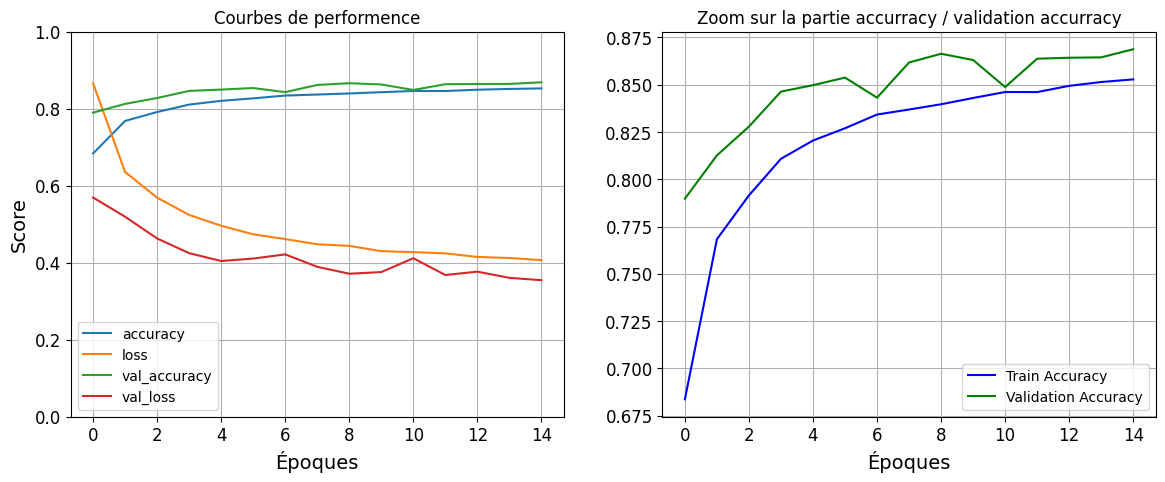

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8686 - loss: 0.3559
score sur l ensemble test  = 0.8687000274658203


In [69]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pd.DataFrame(history.history).plot(ax=axes[0])
axes[0].set_title("Courbes de performence")
axes[0].set_xlabel('Époques')
axes[0].set_ylabel('Score')
axes[0].grid(True)
axes[0].set_ylim(0, 1)


axes[1].plot(history.history['accuracy'], label='Train Accuracy', color = 'blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy',color = 'green')
axes[1].set_xlabel('Époques')
axes[1].set_title("Zoom sur la partie accurracy / validation accurracy")
axes[1].legend()
axes[1].grid(True)


plt.show()

# Évaluation du modèle
print(f'score sur l ensemble test  = {model.evaluate(x_test, y_test)[1]}')


Le score de validation a légèrement chutté, mais on remarque quand meme que le modèle ne surajuste plus comme précédament.

Il est quand même important de reléver que les scores de validation sont légèrement suppérieurs aux scores d'entrainement, ce qui est normal, par ce qu'on a modifié le set d'entrainement lors de l'entrainement en faisant des rotations, des homothéties et des translations... En plus certains neurones ont été désactivés via la commande  Dropout(0.5) lors de l'entrainement, et ne le sont pas lors de la validation.

### Question 2.2.5
Utilisons  un modèle pré-entrainé (VGG16 ou un autre) cette fois  pour tenter d’augmenter la performance du CNN obtenu en 2.2.4
https://keras.io/api/applications/vgg/

In [41]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
conv_base.summary() #Pour consulter les détails du modèle en question

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

x_mean = x_train.mean(axis=0, keepdims=True)
x_std = x_train.std(axis=0, keepdims=True) + 1e-7
x_train = (x_train - x_mean) / x_std
x_valid = (x_valid - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

#en codage des éqtiquettes pour l'utilisation de la fonction log-loss et softmax
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


In [57]:
with tf.device('/GPU:0'):
  x_train = tf.expand_dims(x_train, -1)
  x_valid = tf.expand_dims(x_valid, -1)

  # Conversion en RGB : (28, 28, 1) → (28, 28, 3)
  x_train = tf.image.grayscale_to_rgb(x_train)
  x_valid = tf.image.grayscale_to_rgb(x_valid)

  # Redimensionnement : (28, 28, 3) → (32, 32, 3)
  x_train = tf.image.resize(x_train, [32, 32])
  x_valid = tf.image.resize(x_valid, [32, 32])
  x_train = x_train / 255.0
  x_valid = x_valid / 255.0
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])
  start = time.time()
  history = model.fit(x_train, y_train, epochs=25, batch_size=20, validation_data=(x_valid, y_valid))
  end = time.time()
print(f"Temps d'entraînement : {(end - start):.2f} secondes")


Epoch 1/25
 461/2750 ━━━━━━━━━━━━━━━━━━━━ 1:12:55 2s/step - acc: 0.1943 - loss: 2.4096

KeyboardInterrupt: 

In [54]:
#Le travail étant terminé ici, on libère le GPU pour
import gc
import tensorflow.keras.backend as K

K.clear_session()
gc.collect()


0